# A Random Forest approach for anomaly detection 
## Shaopeng Guo, Zhou He, Tianhan Wei
This notebook provides a walkthrough of using either one day or three days' data to train a random forest classifier and predict whether there will be any machine anomaly in the coming day. 

#### The best result achieved using this model was 0.65324, ranked second on the Kaggle leaderboard (the entry by Samuel He).

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer
from sklearn.model_selection import StratifiedShuffleSplit as stratifiedsplit
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

### Preprocess the data. 
All the missing blanks in the data are imputed by the mean of other data points in the same column;

Either the columns of the previous one day or previous three days will be used as feature, with the status 0/1 of the next day being the label;

It was proven by validation set that doing data normalization does not help boosting performance in this setting.

In [4]:
using_three_days_data = False

# prepare the grand raw data x and y
xl = pd.ExcelFile("feature_stripped.xlsx")
df = xl.parse("feature")
labels = pd.read_csv('train_label.csv')
labels = labels.values[1:,1]
features = df.values
x = features[:,1:]
y = labels
imputer = Imputer(missing_values='NaN')
x = imputer.fit_transform(x,y)
y = y.astype(np.int32)

if using_three_days_data:
    x2 = np.zeros_like(x)
    x2[1:,:] = x[:-1,:]
    x3 = np.zeros_like(x)
    x3[2:,:] = x[:-2:]
    x = np.concatenate([x,x2,x3],axis=1)[2:,:]
    print(x.shape)
    y = y[2:]
    print(y.shape)

### Perform Stratified splitting (distribute the data samples to training set and validation set such that these two sets have the same proportion of positive labels)

Training set has 70% of labeled data while validation set has 30%. Each set has the same percentage of positive labeled data.

After stratified splitting, train a Random Forest Classifier using the train set with max depth = 2 and validate its ROC AUC score on validation set. The process is repeated for 100 times since there will be different ways to split the train+val data.

In [38]:
splitter = stratifiedsplit(n_splits=100,test_size=0.3)
aucs = []
bestpred = None
valyforbestpred = None
bestclassifier = None
highestscore = 0.0
for train_index, val_index in splitter.split(x[:-300], y):
    train_x, val_x = x[train_index], x[val_index]
    train_y, val_y = y[train_index], y[val_index]
    clf = RandomForestClassifier(max_depth=2, random_state=0)
    clf.fit(train_x, train_y)
    results = clf.predict_proba(val_x)[:,1]
    aucscore = roc_auc_score(val_y,results)
    if aucscore > highestscore:
        highestscore = aucscore
        bestpred = results
        valyforbestpred = val_y
        bestclassifier = clf
    aucs.append(aucscore)
print("The avearge AUC for these trials is ", np.average(aucs))
print("The highest AUC for these trials is ", highestscore)

The avearge AUC for these trials is  0.522379807692
The highest AUC for these trials is  0.708934294872


### Plot the ROC curve to visualize the best model
The best model (the one corresponding to the highest AUC obtained from the previous step) is visualized and utilized to generate the prediction on test set.

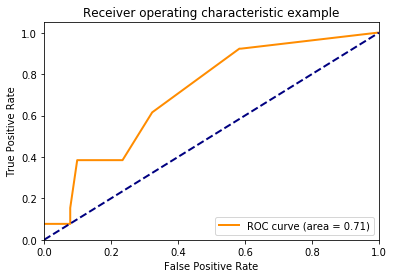

In [39]:
#plot ROC curve
fpr, tpr, _ = roc_curve(valyforbestpred, bestpred)
rocauc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % rocauc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Write outputs to a CSV file

In [40]:
test_x = x[-300:,]
result = bestclassifier.predict_proba(test_x)
output = pd.read_csv('test_label_sample.csv')
with open ('submission6.csv','w') as file:
    file.write('date,label\n')
    for i in range(300):
        file.write(str(output['date'][i]) + ','+str(result[i,1])+'\n')